In [1]:
%load_ext autoreload
%load_ext tensorboard
%matplotlib inline

In [2]:
import matplotlib
import numpy as np
import os
import random
import yaml
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rc
from matplotlib import cm
import seaborn as sns
from importlib import reload
from pathlib import Path
import sklearn
import joblib
import torch
import pandas as pd
import copy

# Utils

In [3]:

from collections import defaultdict

def process_results(results, model_names):
    processed_results = defaultdict(lambda: defaultdict(list))
    for split, split_results in results.items():
        for key, vals in split_results.items():
            model_found = None
            var_found = None
            vals_found = None
            for model_cand_name in model_names:
                if ("_"  + model_cand_name) in key:
                    var_found, model_found = key.split(model_cand_name)
                    model_found = model_cand_name + model_found
                    var_found = var_found[:-1]  # Get rid of the end "_"
                    vals_found = vals
                    break
            if model_found is None:
                continue

            processed_results[var_found][model_found].append(vals_found)
    for var_found, models in processed_results.items():
        for model_found, vals in models.items():
            processed_results[var_found][model_found] = np.array(vals)
    return processed_results

def get_intervention_accuracies(
    results,
    model_name,
    policy_name=None,
    competence_level=1,
    group_level=True,
):
    key = f'test_acc_y_{policy_name}_ints'
    if (competence_level is not None) and (competence_level != 1):
        if group_level:
            key = f'test_acc_y_{policy_name}_ints_competence_gl_{competence_level}'
        else:
            key = f'test_acc_y_{policy_name}_ints_competence_{competence_level}'

        if not key in results:
            if group_level:
                key = f'test_acc_y_{policy_name}_ints_co_{competence_level}_gl'
            else:
                key = f'test_acc_y_{policy_name}_ints_co_{competence_level}'
    metric_results = results[key]
    if model_name not in metric_results:
        raise ValueError(
            f'We could not find {model_name} amongst models {list(metric_results.keys())}'
        )
    y_acc_vals = metric_results[model_name]
    y_acc_vals = np.array(y_acc_vals) * 100
    means = np.mean(y_acc_vals, axis=0)
    stds = np.std(y_acc_vals, axis=0)
    return means, stds

# Global Variables

In [4]:
################################################################################
## Global Variables Defining Experiment Flow
################################################################################

GPU = 1
NUM_WORKERS = 8
rc('text', usetex=False)
plt.style.use('seaborn-whitegrid')
plt.rcParams["font.family"] = "serif"

# Load Combined Results

In [5]:
RESULTS_DIR = "./results/"
CUB_RESULTS_DIR = os.path.join(
    RESULTS_DIR,
    "cub",
)
CUB_RESULTS = joblib.load(os.path.join(CUB_RESULTS_DIR, 'results.joblib'))


In [6]:
def filter_results(results, model_configs, ds_path, fun):
    output = copy.deepcopy(results)
    methods_to_remove = []
    for method_name in output['test_acc_y'].keys():
        for arch in ['lambda', 'resnet34', 'resnet18']:
            config_path = os.path.join(
                ds_path,
                f"{method_name}_{arch}_fold_1_experiment_config.joblib",
            )
            if os.path.exists(config_path):
                model_configs[method_name] = joblib.load(config_path)
                break
        if method_name not in model_configs:
            continue
            # raise ValueError(method_name, config_path)
        if fun(model_configs[method_name]):
            methods_to_remove.append(method_name)
    print("Removing", methods_to_remove)
    for method_name in methods_to_remove:
        for metric_name, other_method_name in list(results.items()):
            if method_name in other_method_name:
                del output[metric_name][method_name]
    return output

def _get_single_rollout(config):
    return (
        (config['architecture'] == 'IntAwareConceptEmbeddingModel') and 
        (config.get('horizon_rate', 1.005) != 1)
    )

In [7]:
sorting_key = 'test_acc_y_group_random_ints'
sorting_fn = lambda x: np.mean([x[len(x)//2] for x in x]) #np.mean
all_processed_results = {}
intcem_var_names = {}
model_configs = defaultdict(dict)
model_names = [
    'ConceptEmbeddingModel',
    'IntAwareConceptEmbeddingModel',
    'ConceptBottleneckModelLogit',
    'ConceptBottleneckModelSigmoid',
    'SequentialConceptBottleneckModel',
    'IndependentConceptBottleneckModel',
]
ALL_DS = [
    ("CUB", CUB_RESULTS, CUB_RESULTS_DIR),
]
for dataset_name, dataset_results, ds_path in ALL_DS:
    print(dataset_name)
    og_processed_results = process_results(dataset_results, model_names)
    models_by_acc = sorted(
        [
            (model_name, sorting_fn(vals)) for model_name, vals in og_processed_results[sorting_key].items() if "IntAware" in model_name
        ],
        key=lambda x: x[1],
        reverse=True,
    )
    print(models_by_acc)
    if models_by_acc:
        intcem_var_names[dataset_name] = models_by_acc[0][0]
    

    all_processed_results[dataset_name] = og_processed_results
    filter_results(all_processed_results[dataset_name], model_configs[dataset_name], ds_path, lambda _: False)

CUB
[('IntAwareConceptEmbeddingModel_int_weight_1_horizon_rate_1.005_int_discount_1_task_discount_1.1', 0.9960116582297899), ('IntAwareConceptEmbeddingModel_rand_comp_trained_int_weight_1_horizon_rate_1.005_int_discount_1_task_discount_1.1', 0.9876514802883878), ('IntAwareConceptEmbeddingModel_comp_aware_int_weight_1_horizon_rate_1.005_int_discount_1_task_discount_1.1', 0.9876323055683387)]
Removing []


In [8]:
list(all_processed_results['CUB']['test_acc_y'].keys())

['IntAwareConceptEmbeddingModel_comp_aware_int_weight_1_horizon_rate_1.005_int_discount_1_task_discount_1.1',
 'IntAwareConceptEmbeddingModel_rand_comp_trained_int_weight_1_horizon_rate_1.005_int_discount_1_task_discount_1.1',
 'IntAwareConceptEmbeddingModel_int_weight_1_horizon_rate_1.005_int_discount_1_task_discount_1.1',
 'ConceptEmbeddingModel',
 'ConceptBottleneckModelSigmoid',
 'ConceptBottleneckModelLogit',
 'IndependentConceptBottleneckModel',
 'SequentialConceptBottleneckModel']

# Dataset Analysis

In [9]:
import datetime
import yaml
reload(yaml)
import io
from contextlib import redirect_stdout
from torchvision.models import resnet18, resnet34, resnet50, densenet121
import re
yaml.add_implicit_resolver("tag:yaml.org,2002:python/name:__main__.c_extractor_arch", re.compile(r'^\d+d\d+$'))
import cem.data.CUB200.cub_loader as cub_data_module
import cem.data.mnist_add as mnist_data_module
import cem.data.celeba_loader as celeba_data_module
ALL_DS_LOADERS = [
    # ("MNIST-Add", MNIST_RESULTS, MNIST_RESULTS_DIR, mnist_data_module, '/anfs/bigdisc/me466/'),
    # ("MNIST-Add-Incomp", MNIST_REDUCED_RESULTS, MNIST_REDUCED_RESULTS_DIR, mnist_data_module, '/anfs/bigdisc/me466/'),
    ("CUB", CUB_RESULTS, CUB_RESULTS_DIR, cub_data_module, '/homes/me466/data/CUB200/'),
    # ("CUB-Incomp", CUB_SUBSAMPLE_RESULTS, CUB_SUBSAMPLE_RESULTS_DIR, cub_data_module, '/homes/me466/UncertaintyIntervention/cem/data/CUB200/'),
    # ("CelebA", CELEBA_RESULTS, CELEBA_RESULTS_DIR, celeba_data_module, '/anfs/bigdisc/me466'),
]
for dataset_name, dataset_results, ds_path, ds_loader, root_dir in ALL_DS_LOADERS:
    # Iterate over files in directory ds_path
    experiment_configs = []
    for file_name in os.listdir(ds_path):
        found = None
        for arch_name in ["lambda", "resnet18", "resnet34", "resnet50", "densenet121"]:
            if file_name.endswith(f'ConceptEmbeddingModel_{arch_name}_fold_1_experiment_config.joblib'):
                found = file_name
                break
        if not found:
            continue
        # if not file_name.startswith('experiment_'):
        #     continue
        # with open(os.path.join(ds_path, file_name), "r") as f:
        #     experiment_config = yaml.load(f, Loader=yaml.Loader)
        experiment_config = joblib.load(os.path.join(ds_path, found))
        if 'shared_params' not in experiment_config:
            experiment_config['shared_params'] = {}
        # Move all global things into the shared params
        for key, vals in experiment_config.items():
            if key not in ['runs', 'shared_params']:
                experiment_config['shared_params'][key] = vals
        experiment_config['shared_params']['num_workers'] = 6
        experiment_configs.append(experiment_config)
        # experiment_configs.append(
        #     (datetime.strptime(file_name[len("experiment_"):-len("_config.yaml")], '%Y_%m_%d_%H_%M'), experiment_config)
        # )
    # experiment_configs = sorted(experiment_configs, key=lambda x: x[0])
    # print(experiment_configs)
    # experiment_config = experiment_configs[-1][1]
    experiment_config = experiment_configs[-1]
    # print(experiment_config)
    f = io.StringIO()
    with redirect_stdout(f):
        train_dl, val_dl, test_dl, imbalance, (n_concepts, n_tasks, concept_map) = \
            ds_loader.generate_data(
                config=experiment_config['shared_params'],
                seed=42,
                output_dataset_vars=True,
                root_dir=root_dir,
            )
    train_samples = len(train_dl.dataset)# * experiment_config['shared_params']['batch_size']
    val_samples = len(val_dl.dataset)# * experiment_config['shared_params']['batch_size']
    test_samples = len(test_dl.dataset)# * experiment_config['shared_params']['batch_size']
    input_shape = train_dl.dataset[0][0].shape
    n_groups = len(concept_map) if concept_map is not None else n_concepts
    print(
        f"\\texttt{{{dataset_name}}} &\n" +
        f"    {train_samples + val_samples} &\n" +
        # f"    ${train_samples + val_samples:.2E}}}$ &\n".replace("E-0", "\\times 10^{-").replace("E+0", "\\times 10^{") +
        f"    {test_samples} &\n" +
        # f"    {test_samples:.2E} &\n" +
        f"    {list(input_shape)} &\n" +
        f"    {n_concepts} &\n" +
        f"    {n_groups} &\n" +
        f"    {n_tasks} \\\\\n"
    )

Global seed set to 42


\texttt{CUB} &
    5994 &
    5794 &
    [3, 299, 299] &
    112 &
    28 &
    200 \\



# Plot All Policies Across All Datasets

['ConceptBottleneckModelLogit', 'ConceptBottleneckModelSigmoid', 'ConceptEmbeddingModel', 'IndependentConceptBottleneckModel', 'IntAwareConceptEmbeddingModel_comp_aware_int_weight_1_horizon_rate_1.005_int_discount_1_task_discount_1.1', 'IntAwareConceptEmbeddingModel_int_weight_1_horizon_rate_1.005_int_discount_1_task_discount_1.1', 'IntAwareConceptEmbeddingModel_rand_comp_trained_int_weight_1_horizon_rate_1.005_int_discount_1_task_discount_1.1', 'SequentialConceptBottleneckModel']
Ignoring ConceptBottleneckModelLogit
Ignoring ConceptBottleneckModelSigmoid
HERE WITH ConceptEmbeddingModel
human_policy_name = Learnt
policy_name = group_random


ValueError: We could not find ConceptEmbeddingModel amongst models ['IntAwareConceptEmbeddingModel_comp_aware_int_weight_1_horizon_rate_1.005_int_discount_1_task_discount_1.1', 'IntAwareConceptEmbeddingModel_rand_comp_trained_int_weight_1_horizon_rate_1.005_int_discount_1_task_discount_1.1', 'IntAwareConceptEmbeddingModel_int_weight_1_horizon_rate_1.005_int_discount_1_task_discount_1.1']

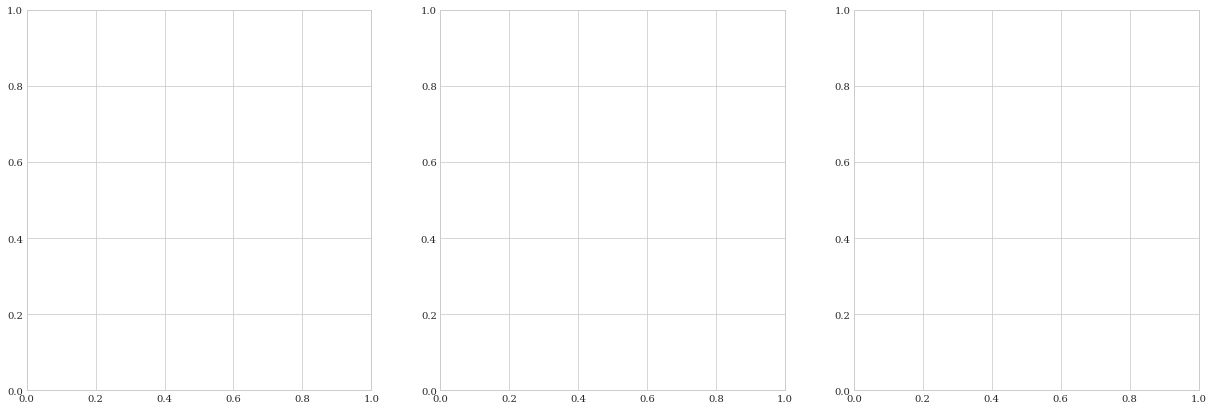

In [18]:

import itertools
clrs = sns.color_palette("Set1", 20)
color_map = {}
model_name_to_marker = {
    'IntAwareConceptEmbeddingModel': '|',
    'IntAwareConceptEmbeddingModel_comp': '*',
    'IntAwareConceptEmbeddingModel_rand_mistakes': 's',
    'ConceptBottleneckModelLogit': '.',
    'ConceptBottleneckModelSigmoid': 'x',
    'ConceptEmbeddingModel': 'd',
    'SequentialConceptBottleneckModel': 's',
    'IndependentConceptBottleneckModel': 'o',
}
used_policies = {
    'IntAwareConceptEmbeddingModel': ("Random", "group_random"),
}
datasets_to_use = [
    "CUB",
]
labels = []
handles = []
width = 7
height = 7
label_size = 18
title_size = 20
legend_size = 18
tick_size = 16
marker_size_large = 100
square_marker_size = 20
marker_size_small = marker_size_large/2
markerscale = 2.5
competencies = [1, 0, 'unif']
fig, axs = plt.subplots(
    len(datasets_to_use),
    len(competencies),
    figsize=(len(competencies)*width, len(datasets_to_use)*height),
    squeeze=False,
)
for dataset_idx, dataset_name in enumerate(datasets_to_use):
    markers = itertools.cycle(('1', '+', 'o', 'd', 's' ,'v'))
    dataset_results = all_processed_results[dataset_name]
    method_to_actual_name = {
        'ConceptEmbeddingModel': 'CEM',
        # 'ConceptBottleneckModelLogit': "Joint CBM-Logit",
        'ConceptBottleneckModelSigmoid': "Joint CBM-Sigmoid",
        # 'SequentialConceptBottleneckModel': "Sequential CBM",
        # 'IndependentConceptBottleneckModel': "Independent CBM",
    }
    model_names = sorted([
        name for name in dataset_results['test_acc_y'].keys()
    ])
    print(model_names)
    for competence_idx, competence in enumerate(competencies):
        for method_idx, method_name in enumerate(model_names):
            ax = axs[dataset_idx, competence_idx]
            marker = model_name_to_marker.get(method_name,'.')
            if method_name.startswith("IntAwareConceptEmbeddingModel"):
                if "rand_comp_trained" in method_name:
                    mode = 'IntAwareConceptEmbeddingModel_rand_mistakes'
                else:
                    mode = 'IntAwareConceptEmbeddingModel_comp' if (
                        method_name.startswith("IntAwareConceptEmbeddingModel_comp_aware")
                    ) else 'IntAwareConceptEmbeddingModel'
                marker = model_name_to_marker.get(mode,'.')
                config = model_configs[dataset_name][method_name]
                if config['intervention_weight'] != 1:
                    print("IGNORING", method_name)
                    continue
                if config['intervention_weight'] != 0:
                    if "rand_comp_trained" in method_name:
                        method_to_actual_name[method_name] = f"IntCEM + Rand Mistakes ($\\alpha = {config['intervention_weight']}$)"
                    else:
                        method_to_actual_name[method_name] = f"IntCEM-Comp ($\\alpha = {config['intervention_weight']}$)" if (
                            method_name.startswith("IntAwareConceptEmbeddingModel_comp_aware")
                        ) else f"IntCEM ($\\alpha = {config['intervention_weight']}$)"

                else:
                    if "rand_comp_trained" in method_name:
                        method_to_actual_name[method_name] = f"IntCEM + Rand Mistakes"
                    else:
                        method_to_actual_name[method_name] = f"IntCEM-Comp" if (
                            method_name.startswith("IntAwareConceptEmbeddingModel_comp_aware")
                        ) else f"IntCEM"
                        method_to_actual_name[method_name] = (
                            f"{method_to_actual_name[method_name]} no $\psi$"
                        )
                    marker = "+"

            if method_name not in method_to_actual_name:
                print("Ignoring", method_name)
                continue
            print("HERE WITH", method_name)
            og_method_name = method_name
            config = model_configs[dataset_name][method_name]

            human_policy_name, policy_name = used_policies.get(
                method_name,
                ("Random", "group_random_no_prior"),
                # ("Learnt", "group_random"),
            )
            print("human_policy_name =", human_policy_name)
            print("policy_name =", policy_name)
            if policy_name == "group_random" and "IntAware" in method_name:
                human_policy_name = "Learnt"
            means, stds = get_intervention_accuracies(
                dataset_results,
                method_name,
                policy_name=policy_name,
                competence_level=competence,
            )
            method_name = method_to_actual_name.get(method_name, method_name)
            if method_name not in color_map:
                color_map[method_name] = clrs[len(color_map)]
            color = color_map[method_name]
            x_vals = list(range(0, len(means), 1))
            ax.plot(
                x_vals,
                means,
                c=color,
                zorder=1,
            )
            ax.scatter(
                x_vals,
                means,
                s=marker_size_large if marker in ['+', 'x', '1'] else marker_size_small,
                label=(
                    f'{method_name} ({human_policy_name} Policy)'
                    if human_policy_name != "Learnt"
                    else f'{method_name} ({human_policy_name} Policy $\psi$)'
                ),
                color=color,
                zorder=2,
                marker=marker,
            )
            ax.fill_between(
                x_vals,
                means - stds,
                means + stds,
                alpha=0.3,
                facecolor=color,
            )
            new_handles, new_labels = ax.get_legend_handles_labels()
            for label, handle in zip(new_labels, new_handles):
                if label not in labels:
                    labels.append(label)
                    handles.append(handle)
        ax.xaxis.set_tick_params(labelsize=tick_size)
        ax.yaxis.set_tick_params(labelsize=tick_size)
        ax.set_xticks(x_vals[::2] if len(x_vals) < 10 else x_vals[::4])
        ax.set_xlabel(f"Groups Intervened", fontsize=label_size)
        if dataset_idx == 0:
            ax.set_title(f"Competence Level {competence}",  fontsize=title_size)
        if competence_idx == 0:
            ax.set_ylabel(
                dataset_name + f"\nTask Accuracy (%)",
                fontsize=label_size,
            )
        ax.grid(False)
    # handles, labels = ax.get_legend_handles_labels()
lgd = fig.legend(
    handles,
    labels,
    fontsize=legend_size,
    loc='upper center',
    bbox_to_anchor=(0.5,-0.01),
    ncol=3,
    markerscale=markerscale,
)
plt.tight_layout()
plt.savefig("figures/competency_intcem_policy_results.pdf", bbox_inches='tight')
plt.savefig("figures/competency_intcem_policy_results.png", bbox_inches='tight')
plt.show()